In [6]:
from utils import LMDBDataset
import numpy as np

dataset = LMDBDataset('data/graphs/PUBCHEM_16', split='train')
print(len(dataset))

14000748


In [2]:
graph = dataset[0]
node_labels = graph['node_labels']
print(node_labels.shape)
adjacency_matrix = graph['adjacency_matrix']
print(adjacency_matrix.shape)
edge_labels = graph['edge_labels']
print(edge_labels.shape)
SP_matrix = graph['SP_matrix']
print(SP_matrix.shape)
print(SP_matrix[:10,:10])

torch.Size([16, 32])
torch.Size([16, 16])
torch.Size([16, 16, 6])
torch.Size([16, 16])
tensor([[0, 1, 2, 3, 4, 3, 2, 5, 4, 5],
        [1, 0, 1, 2, 3, 2, 1, 4, 3, 4],
        [2, 1, 0, 1, 2, 3, 2, 3, 2, 3],
        [3, 2, 1, 0, 1, 2, 3, 2, 1, 2],
        [4, 3, 2, 1, 0, 1, 2, 1, 2, 3],
        [3, 2, 3, 2, 1, 0, 1, 2, 3, 4],
        [2, 1, 2, 3, 2, 1, 0, 3, 4, 5],
        [5, 4, 3, 2, 1, 2, 3, 0, 3, 4],
        [4, 3, 2, 1, 2, 3, 4, 3, 0, 1],
        [5, 4, 3, 2, 3, 4, 5, 4, 1, 0]], dtype=torch.uint8)


In [21]:
n = min(10000, len(dataset))

def iterate_dataset(dataset):  
    for i in range(n):
        data = dataset[i]
        if isinstance(data, tuple):
            graph, target = data
        else:
            graph = data
        yield graph

In [28]:
all_dists = []
all_sizes = []
all_node_labels = []
all_node_labels_per_graph = []
for graph in iterate_dataset(dataset):
    all_sizes.append(len(graph['node_labels']))
    all_dists.append(graph['SP_matrix'].amax())
    all_node_labels.append(graph['node_labels'].numpy())
    node_labels_in_graph = graph['node_labels'].sum(axis=0).numpy()
    node_labels_in_graph = np.where(node_labels_in_graph > 0, 1, 0)
    all_node_labels_per_graph.append(node_labels_in_graph)
all_dists = np.array(all_dists)
all_sizes = np.array(all_sizes)
all_node_labels = np.concatenate(all_node_labels)
node_labels_freq = all_node_labels.sum(axis=0)
node_labels_freq = node_labels_freq 
all_node_labels_per_graph = np.stack(all_node_labels_per_graph)
node_labels_freq_per_graph = all_node_labels_per_graph.sum(axis=0)
node_labels_freq_per_graph = node_labels_freq_per_graph 

print(all_dists.mean(), all_dists.std())
print(all_sizes.mean(), all_sizes.std())
print(node_labels_freq)
print(node_labels_freq_per_graph)

7.2552 1.5978964171685222
13.7807 2.115563166156946
[96800 14605 12967  2354  1794  4825  1991   192   533   233     1    18
     1    23   362     0     0     0     0    65     3     0     0     0
     0     0   985     0     0     0     2    53]
[9980 7469 6691 1870 1597 2678 1811  158  492  188    1   18    1   22
  354    0    0    0    0   56    2    0    0    0    0    0  324    0
    0    0    2   43]


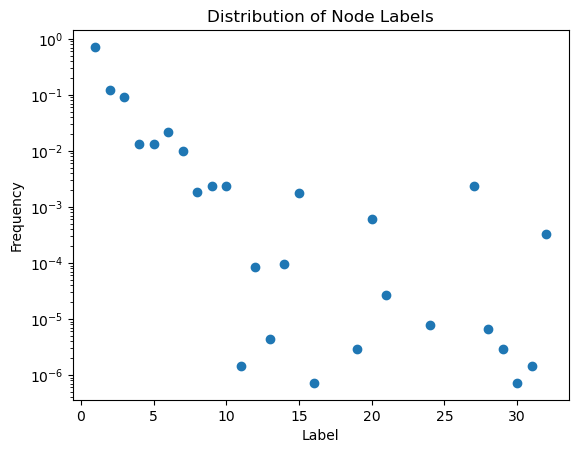

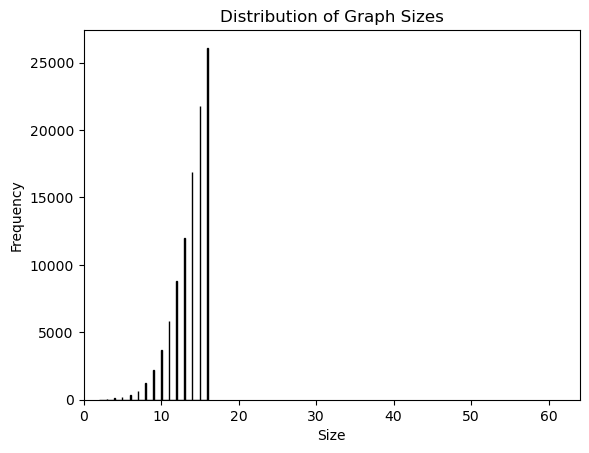

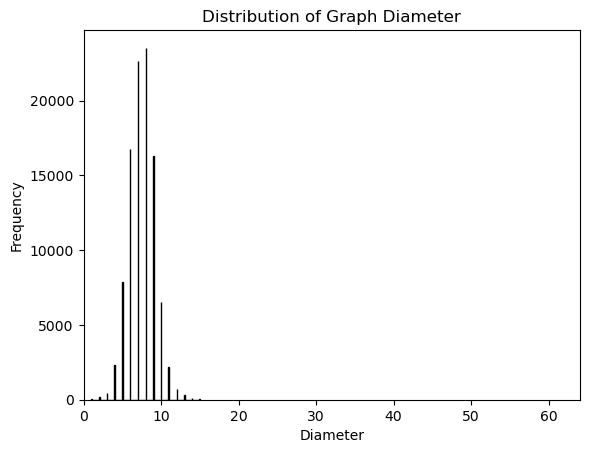

In [19]:
import matplotlib.pyplot as plt

plt.scatter(range(1, 1 + len(node_labels_freq)), node_labels_freq)
plt.yscale('log')
plt.title('Distribution of Node Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

plt.hist(all_sizes, bins=200, edgecolor='black')
plt.xlim(0, 64)
plt.title('Distribution of Graph Sizes')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show()

plt.hist(all_dists, bins=200, edgecolor='black')
plt.xlim(0, 64)
plt.title('Distribution of Graph Diameter')
plt.xlabel('Diameter')
plt.ylabel('Frequency')
plt.show()